In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import lumerical as lum
from scipy.constants import pi

In [9]:
lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

In [3]:
from scipy.constants import pi, c
um = 1e-6
nm = 1e-9
THz = 1e12

## Main Waveguide Parameters

In [27]:
'''
Input parameters
'''
wl_pump = 1*um
wl_signal = 2*wl_pump
h_LN = 700*nm
h_etch = 350*nm
w_ridge = 1850*nm
h_slab = h_LN - h_etch

theta = 60
wg_length = 10*um
w_ridge_base = w_ridge + 2*h_etch/np.tan(theta*pi/180)

print('slab = %0.1f nm' %(h_slab/nm) )
print('width at the base = %.3f um' %(w_ridge_base/um) )

'''
Simulation volume
'''
w_slab = 10*wl_pump + 2*w_ridge
h_margin = 4*wl_pump
h_substrate = 4*wl_pump
meshsize = wl_pump/20
finemesh = wl_pump/40

'''
Materials
'''
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

slab = 350.0 nm
width at the base = 2.254 um


## Dispersion Sweeps

In [5]:
freq_start = 140*THz
freq_stop = 310*THz
freq_step = 5*THz
freqs = np.arange(freq_start, freq_stop, freq_step)
n =  freqs.size

neff = np.zeros([n])
vg = np.zeros([n])
gvd = np.zeros([n])
beta = np.zeros([n])

In [20]:
lum.draw_wg(MODE, material_thinfilm, material_substrate,
          h_LN, h_substrate, h_etch, w_ridge, w_slab, theta, wg_length)
lum.add_fine_mesh(MODE, finemesh, h_LN, w_ridge_base, x_factor=1.2, y_factor=1.5)
lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin, symmetry='TE')

In [7]:
for kf in range(n):
    wavelength = c/freqs[kf]
    _neff, _ng, _loss, _te = lum.solve_mode(MODE, wavelength, nmodes=20)
    for m in range(_te.size):
        if _te[m]>0.9:
            neff[kf] = _neff[m]
            vg[kf], gvd[kf] = lum.dispersion_analysis(MODE, wavelength, m+1)
            break

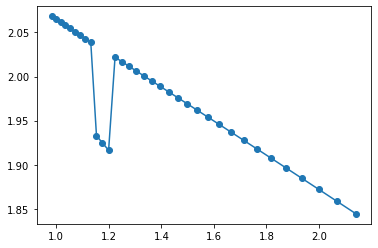

In [19]:
plt.plot(c/freqs/um, neff, 'o-')

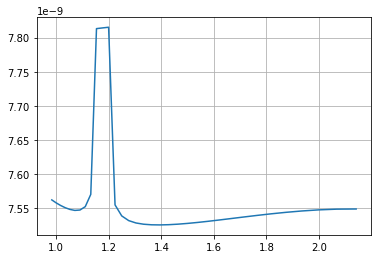

In [17]:
plt.plot(c/freqs/um, 1/vg)
plt.grid(True)

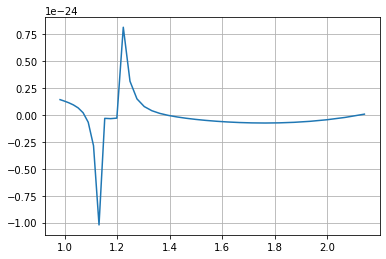

In [18]:
plt.plot(c/freqs/um, gvd)
plt.grid(True)

## Poling Period

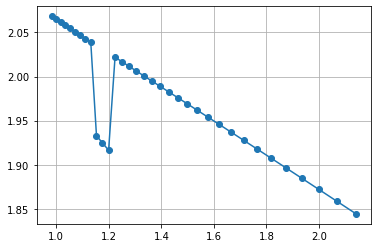

In [42]:
plt.plot(c/freqs/um, neff, 'o-')
# plt.xlim([0.9,1.1])
plt.grid(True)

In [53]:
c/freqs[1]

2.067534193103448e-06

In [54]:
ns = neff[1]
np = neff[-5]
poling_period = wl_pump / (np - ns)
print(poling_period/um)

5.1014845456683515


## Coupler Design

In [24]:
#Coupler gap at the base
gap = 1*um
w_total = w_ridge_base
w_sidewall = h_etch/np.tan(theta*pi/180)

MODE.switchtolayout()
MODE.deleteall()
lum.draw_substrate(MODE, material_thinfilm, material_substrate, h_LN, h_substrate, 
                   h_etch, w_slab, wg_length, x0=0)
lum.draw_ridge(MODE, material_thinfilm, h_LN, h_etch, w_ridge, theta, wg_length, 
               x0=w_total/2+gap/2, name='wg1')
lum.draw_ridge(MODE, material_thinfilm, h_LN, h_etch, w_ridge, theta, wg_length, 
               x0=-w_total/2-gap/2, name='wg2')
  
lum.add_fine_mesh(MODE, finemesh, h_LN, 2*w_total+gap, x_factor=1.2, y_factor=1.5)
MODE.set('name','Outer mesh')
lum.add_fine_mesh_lowlevel(MODE, finemesh/2, 0, h_slab+h_etch/2, (gap+2*w_sidewall)*1.4, h_etch*1.4)
MODE.set('name','Inner mesh')

lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin)

In [28]:
wavelength = wl_signal
_neff, _ng, _loss, _te = lum.solve_mode(MODE, wavelength, nmodes=20)

In [30]:
'''
Get first two TE modes,
these are the even and odd modes
'''
even = True
for km in range(_neff.size):
    if _te[km]>0.8:
        if even:
            neff_sym = _neff[km]
            even = False
        else:
            neff_asym = _neff[km]
            break #Found both modes, get out

delta_n = neff_sym - neff_asym
Lc = wavelength/(2*delta_n)

In [33]:
print(Lc)

0.0012387340859488917


In [35]:
delta_n

0.000807275759457271